In [2]:

import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import scipy.io.wavfile as wav
from os.path import isfile, join
from scipy.fftpack import dct
from python_speech_features import mfcc
from os import listdir, path
from keras.utils import np_utils
from tensorflow.keras.layers import (Embedding, LSTM, GRU, Dense, MaxPooling1D, 
                                      Dropout, Reshape, LeakyReLU, ReLU, Flatten, 
                                      concatenate, Bidirectional, TimeDistributed, 
                                      add, Conv1D, SeparableConv1D, GlobalMaxPooling2D, 
                                      GlobalAveragePooling2D
                                     , Conv2D, Input, Activation, 
                                      BatchNormalization, MaxPooling2D, GlobalMaxPooling1D,
                                      GlobalAveragePooling1D)
from tensorflow.keras.models import (Sequential, load_model, Model)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping)
from tensorflow.keras import regularizers
from tensorflow.keras.applications.densenet import DenseNet201

from sklearn.metrics import (confusion_matrix, classification_report, 
                             roc_curve, auc)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [4]:
print(tf.config.list_physical_devices('GPU'))

[]


# 1. Pre Processing the Data

In [6]:
BASE_PATH = './input/final_database/'
DATASET_PATH = './input/final_database/dataset/'
DEMOGRAPHIC_NAMES = ['Patient Number', 'Age', 'Sex', 'Adult BMI (kg/m2)', 'Child Weight (kg)', 'Child Height (cm)']
DIAGNOSIS_NAMES = ['Patient Number', 'Diagnosis']

df_demographic = pd.read_csv(f'{BASE_PATH}/ICBHI_Challenge_demographic_information.txt', names = DEMOGRAPHIC_NAMES, sep = '\t')
df_diagnosis = pd.read_csv(f'{BASE_PATH}/ICBHI_Challenge_diagnosis.txt', names = DIAGNOSIS_NAMES, sep='\t')
df_demographic.head()

,Patient Number,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm)
0,101,3.00,F,NaN,19.0,99.0
1,102,0.75,F,NaN,9.8,73.0
2,103,70.00,F,33.00,NaN,NaN
3,104,70.00,F,28.47,NaN,NaN
4,105,7.00,F,NaN,32.0,135.0


In [7]:
df_diagnosis.head()

,Patient Number,Diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [8]:
df =  df_demographic.merge(df_diagnosis, on=DEMOGRAPHIC_NAMES[0])
df[DIAGNOSIS_NAMES[1]].value_counts()

COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: Diagnosis, dtype: int64

In [9]:
df.head()

,Patient Number,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm),Diagnosis
0,101,3.00,F,NaN,19.0,99.0,URTI
1,102,0.75,F,NaN,9.8,73.0,Healthy
2,103,70.00,F,33.00,NaN,NaN,Asthma
3,104,70.00,F,28.47,NaN,NaN,COPD
4,105,7.00,F,NaN,32.0,135.0,URTI


# 2. Reading Dataset

In [10]:
textfiles = [f for f in listdir(DATASET_PATH) if (os.path.isfile(join(DATASET_PATH, f)) and f.endswith('.txt'))] 
print(f'Total number of test files: {len(textfiles)}')

Total number of test files: 920


## Respiratory Cycle Data

In [11]:
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data=[tokens], columns=['Patient Number', 'Recording Index', 'Chest Location', 'Acquisition mode', 'Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name), names=['Start', 'End', 'Crackles', 'Wheezes'], delimiter='\t')
    recording_info['Recording equipment'] = recording_info['Recording equipment'].str.replace('.txt', '', regex=False)
    return (recording_info, recording_annotations)

In [12]:
i_list = []
rec_annotations = []
rec_annotations_dict = {}
for s in textfiles:
    (i,a) = Extract_Annotation_Data(s, DATASET_PATH)
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[s] = a

my_index = pd.Series(list(rec_annotations_dict.keys()))
recording_info = pd.concat(i_list, axis = 0)
recording_info.head()


,Patient Number,Recording Index,Chest Location,Acquisition mode,Recording equipment
0,174,1p3,Ll,mc,AKGC417L
0,135,2b2,Al,mc,LittC2SE
0,178,1b3,Pr,mc,AKGC417L
0,115,1b1,Ar,sc,Meditron
0,177,1b4,Pr,mc,AKGC417L


In [14]:
res_rate_list = []
for i in range (len(textfiles)):
    cycle_df = pd.DataFrame( list(rec_annotations_dict.values())[i],columns=['Start', 'End' ,'cycle length'])
    cycle_df['cycle length'] = cycle_df['End']-cycle_df['Start']
    average = cycle_df[["Start","End","cycle length"]].mean(axis=0)
    df = pd.DataFrame(average).T
    res_rate_list.append(df)

In [15]:
res_rate_df = pd.concat(res_rate_list,ignore_index =True)
res_rate_df['filename']= my_index.values
res_rate_df['filename']= res_rate_df['filename'].str[:3]
res_rate_df.sort_values(by=['filename'])

,Start,End,cycle length,filename
326,9.365636,11.174727,1.809091,101
621,8.639333,10.300000,1.660667,101
190,9.807231,11.322615,1.515385,102
484,8.778667,12.047833,3.269167,103
443,11.984171,13.811599,1.827429,104
...,...,...,...,...
614,9.380857,12.227714,2.846857,224
754,9.587714,11.012214,1.424500,225
122,9.648818,11.461818,1.813000,226
100,8.942800,10.927100,1.984300,226


In [16]:
# Respiratory cycle = Cycle length // 60 seconds 
avg = res_rate_df.groupby('filename').mean()
avg['respiratory rate'] = 60 // avg['cycle length'] 

# Normal Respiratory Rate (12-25) cycle/min
avg.loc[avg['respiratory rate'] > 25, 'Diagnosis'] = "High" 
avg['Diagnosis'].fillna('Normal', inplace=True)
avg.head()

,Start,End,cycle length,respiratory rate,Diagnosis
filename,,,,,
101,9.002485,10.737364,1.734879,34.0,High
102,9.807231,11.322615,1.515385,39.0,High
103,8.778667,12.047833,3.269167,18.0,Normal
104,8.795221,11.078845,2.283624,26.0,High
105,9.198375,11.682250,2.483875,24.0,Normal


In [17]:
sns.countplot(x='Diagnosis', data=avg)
plt.title('Respiratory Rate Distribution')

Text(0.5, 1.0, 'Respiratory Rate Distribution')

In [18]:
rr_diagnosis = avg[['Diagnosis']].rename_axis('Patient Number').reset_index()
rr_diagnosis.head()

,Patient Number,Diagnosis
0,101,High
1,102,High
2,103,Normal
3,104,High
4,105,Normal


## MFCC Data


In [19]:
filenames = [f for f in listdir(DATASET_PATH) if (os.path.isfile(join(DATASET_PATH, f)) and f.endswith('.wav'))] 

In [20]:

max_pad_len = 862 # to make the length of all MFCC equal

def extract_features(file_name):
    """
    This function takes in the path for an audio file as a string, loads it, and returns the MFCC
    of the audio"""
   
    try:
        # addition_data = rr_diagnosis[rr_diagnosis['Patient Number'] == file_name.split('/')[-1].split('_')[0]][['Diagnosis']].values[0][0]
        # Load audio file and get sample rate
        (rate, signal) = wav.read(file_name)
        
        # Compute MFCCs
        mfccs = mfcc(signal, rate, numcep=40, nfilt=40, nfft=2048)
        
        # Pad or truncate MFCCs to have a fixed length
        pad_width = max_pad_len - mfccs.shape[0]
        if pad_width < 0:
            mfccs = mfccs[:max_pad_len, :]
        else:
            mfccs = np.pad(mfccs, ((0, pad_width), (0, 0)), mode='constant')
    
        
        # mfccs = np.append(mfccs, addition_data)
    except Exception as e:
        print(f"Error encountered while parsing file: {file_name}, {e}")
        return None 
     
    return mfccs

In [21]:
# Needs to be re-run if you want to extract labels again :/

wav_filepaths = [f'{DATASET_PATH}{f}' for f in filenames]

patient_id = np.array([])
features = []

# Iterate through each sound file and extract the features
for file_name in wav_filepaths:
    data = extract_features(file_name)
    if data is not None:
        features.append(data)
        patient_id = np.append(patient_id, file_name.split('/')[-1].split('_')[0])
        
patient_id = patient_id.astype(int)


In [22]:
df_diagnosis = pd.read_csv(f"{BASE_PATH}/ICBHI_Challenge_diagnosis.txt",header=None, sep="\t")
labels = np.array([df_diagnosis[df_diagnosis[0] == x][1].values[0] for x in patient_id])
features = np.array(features)
print(f'Extracted features from {len(features)} files with {len(labels)} labels with {len(patient_id)} patient ids')

Extracted features from 920 files with 920 labels with 920 patient ids


In [23]:
# delete the very rare diseases
features1 = np.delete(features, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0) 

labels1 = np.delete(labels, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

In [24]:
# print class counts
unique, counts = np.unique(labels1, return_counts=True)
print(np.asarray((unique, counts)).T)

[['Bronchiectasis' '16']
 ['Bronchiolitis' '13']
 ['COPD' '793']
 ['Healthy' '35']
 ['Pneumonia' '37']
 ['URTI' '23']]


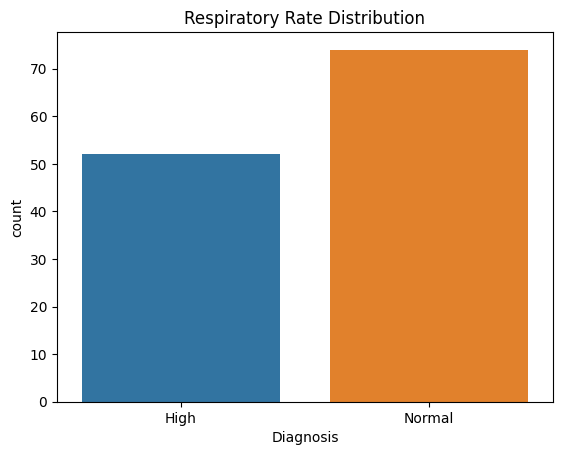

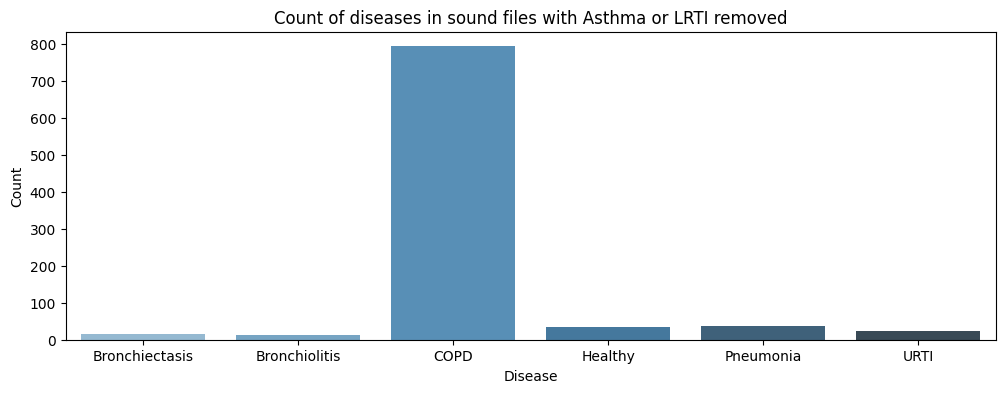

In [25]:
y_pos = np.arange(len(unique))
plt.figure(figsize=(12, 4))
sns.barplot(x=unique, y=counts, palette='Blues_d')
sns.set_style('whitegrid')
plt.xticks(y_pos, unique)
plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Count of diseases in sound files with Asthma or LRTI removed')
plt.show()

In [26]:
# One-hot encode labels
le = LabelEncoder()
i_labels = le.fit_transform(labels1)
oh_labels = to_categorical(i_labels) 


In [27]:
# add channel dimension for CNN
features1 = np.reshape(features1, (*features1.shape,1)) 

# 3. Tensorflow Training

In [28]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(features1, oh_labels, stratify=oh_labels, test_size=0.2, random_state = 42)

In [29]:
num_rows = 862
num_columns = 40
num_channels = 1

num_labels = oh_labels.shape[1]
filter_size = 2


# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))


model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))


model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())
# model.add(TimeDistributed(Flatten()))
# model.add(Dropout(0.4))
# model.add(GRU(units=64, return_sequences=True))
# model.add(GlobalAveragePooling1D())

model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_labels, activation='softmax')) 

In [30]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 
print(tf.config.list_physical_devices('GPU'))

[]


In [31]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print(f"Pre-training accuracy: {accuracy:.4f}%")
tf.keras.utils.plot_model(model, "model.png", show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 861, 39, 16)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 430, 19, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 429, 18, 32)       2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 214, 9, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 213, 8, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 106, 4, 64)       0

In [32]:
# train model
num_epochs = 300
num_batch_size = 128

cb = [EarlyStopping(patience=50,monitor='val_accuracy',mode='max',restore_best_weights=True),
      ModelCheckpoint("./models/rr_LSTM_CNN_1.h5",save_best_only=True,monitor='val_accuracy',mode='max')]   

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=cb, verbose=1, shuffle=True, use_multiprocessing=True)



Epoch 1/300
6/6 [==============================] - 4s 451ms/step - loss: 1.2060 - accuracy: 0.6712 - val_loss: 0.6535 - val_accuracy: 0.8641
Epoch 2/300
6/6 [==============================] - 3s 421ms/step - loss: 0.7375 - accuracy: 0.8608 - val_loss: 0.6641 - val_accuracy: 0.8641
Epoch 3/300
6/6 [==============================] - 2s 419ms/step - loss: 0.7245 - accuracy: 0.8554 - val_loss: 0.7329 - val_accuracy: 0.8641
Epoch 4/300
6/6 [==============================] - 2s 416ms/step - loss: 0.6722 - accuracy: 0.8581 - val_loss: 0.5878 - val_accuracy: 0.8641
Epoch 5/300
6/6 [==============================] - 2s 415ms/step - loss: 0.6482 - accuracy: 0.8649 - val_loss: 0.5873 - val_accuracy: 0.8641
Epoch 6/300
6/6 [==============================] - 2s 417ms/step - loss: 0.5711 - accuracy: 0.8649 - val_loss: 0.5918 - val_accuracy: 0.8641
Epoch 7/300
6/6 [==============================] - 2s 417ms/step - loss: 0.5608 - accuracy: 0.8649 - val_loss: 0.5137 - val_accuracy: 0.8641
Epoch 8/300
6

# 4. Evaluvating the Model

In [39]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.grid()


  # Plot accuracy
  plt.figure()
  plt.grid()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

plot_loss_curves(history)

In [35]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])
plot_loss_curves(history)


Training Accuracy:  0.9236016273498535
Testing Accuracy:  0.9130434989929199


In [36]:
preds = model.predict(x_test) # label scores 

classpreds = np.argmax(preds, axis=1) # predicted classes 

y_testclass = np.argmax(y_test, axis=1) # true classes

n_classes=6 # number of classes

6/6 [==============================] - 0s 31ms/step


In [37]:
# Classification Report
c_names = ['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI']
print(classification_report(y_testclass, classpreds, target_names=c_names))

                precision    recall  f1-score   support

Bronchiectasis       1.00      1.00      1.00         3
 Bronchiolitis       0.00      0.00      0.00         3
          COPD       0.96      0.99      0.98       159
       Healthy       0.41      1.00      0.58         7
     Pneumonia       0.00      0.00      0.00         7
          URTI       0.00      0.00      0.00         5

      accuracy                           0.91       184
     macro avg       0.40      0.50      0.43       184
  weighted avg       0.86      0.91      0.88       184



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
# Confusion Matrix
confusion = confusion_matrix(y_testclass, classpreds)
df_com = pd.DataFrame(confusion, index=c_names, columns=c_names)
plt.figure(figsize=(10, 8))
sns.heatmap(df_com, annot=True, fmt='g', cmap='Blues')

<AxesSubplot:>